In [91]:
import numpy as np
import pandas as pd
from scipy.io import arff
data, meta = arff.loadarff('phishing.arff')

In [92]:
## assigning the column headers
col_headers = data.dtype.names

## converting bytes of .arff type file into string format
## then the literal str type for later dummy variable conversion
df = pd.DataFrame(data, columns = col_headers).stack().str.decode('utf-8').astype(int).unstack()

## split into independent and dependent variables respectively
y = df['Result'].replace(-1, 0)
X = df.drop('Result', axis = 1)
X[X.columns.values] += 1

In [93]:
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest

## selecting the k-best independent features from the original data
def select_k_best_features(X, y, k_best, feature_scorer_fn):
    """
    
    """
    feature_names = list(X.columns.values)
    ## scored by a scorer function for feature selection
    selector = SelectKBest(score_func = feature_scorer_fn, k = k_best).fit(X, y)
    mask = selector.get_support() # list of booleans, index aligning with features selected
    
    ## transform the dataframe into a reduced one w k-best features
    new_features = selector.fit_transform(X, y) 
    new_features_col = [] # The list of your K best features

    ## picking out the feature names from the original df
    for bool, feature in zip(mask, feature_names):
        if bool:
            new_features_col.append(feature)
    
    ## produce new X with k best selected features based on chi-square
    X_new = pd.DataFrame(new_features, columns = new_features_col)
    return X_new

## cross validation on training/validation split set, returns a model with optimal estimators
def fit_model(X, y, classifier, scorer, *params):
    ## validation sets
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
    
    ## making scorer function for Grid Search
    if len(params) > 0:
        scorer = make_scorer(scorer, beta = params[0])
    else:
        scorer = make_scorer(scorer)
        
    ## classifier in question
    if classifier == "SVM":
        clf = SVC(random_state = 0)
        params = {'C': np.logspace(-4, 1, 10), 'kernel':['linear', 'rbf', 'poly'],\
                 'degree': range(2,6)}
    elif classifier == "NB":
        clf = GaussianNB()
        clf = clf.fit(X, y)
        return clf
    elif classifier == "NN":
        clf = MLPClassifier(random_state = 0)
        params = {'hidden_layer_sizes': range(2, 6), 'alpha': np.logspace(-3, 1, 10)}
    elif classifier == "RF":
        clf = RandomForestClassifier(random_state = 0)
        params = {'n_estimators': range(5,11), 'max_depth' : range(3,8)}
    elif classifier == "KNN":
        clf = KNeighborsClassifier()
        params = {'n_neighbors': range(2,9)}
        
    ## categorical independent variables to predict one dependent variable
    elif classifier == "LogR":
        clf = LogisticRegression(random_state = 0)
        params = {'C': np.logspace(-4, 2, 10), 'solver': ['newton-cg', \
                'lbfgs', 'liblinear', 'sag'], 'max_iter': range(500, 5001, 500)}
    else:
        print "Wrong classifier!"
    grid = GridSearchCV(clf, params, scorer, cv = cv_sets)
    grid = grid.fit(X, y)
    
    ## to check which range of estimators we're working with in the learning algorithm.
    print grid.best_estimator_ 
    return grid

### Feature Selection through chi-squared test

##### The Chi-squared test is relevant to our particular dataset as the independent predictors are all comprised of categorical variables.

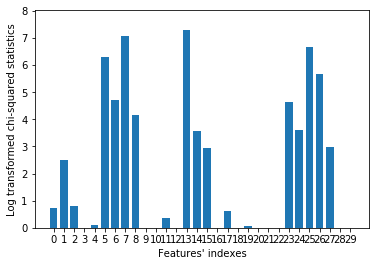

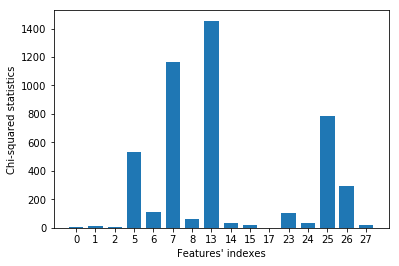

In [94]:
import pylab as pl

no_of_features = range(len(X.columns))
selector = SelectKBest(score_func = chi2, k = 'all').fit(X, y)
feature_score = selector.scores_
d = dict(zip(no_of_features, feature_score))

## all features
X_plot = np.arange(len(d))
pl.bar(X_plot, np.log(d.values()), align='center', width=0.75)
pl.xticks(X_plot, d.keys())
ymax = max(np.log(d.values()))*1.1
pl.ylim(0, ymax)
pl.xlabel("Features' indexes")
pl.ylabel('Log transformed chi-squared statistics')
pl.title('Features & their respective chi-squared statistics')
pl.show()

## exclude features with chi-squared values of 0
d_new = {}
removed = {}
for idx, value in d.items():
    if np.log(value) > 0.6:
        d_new[idx] = value 
    else:
        removed[idx] = X.columns.values[idx]

X_plot = np.arange(len(d_new))
pl.bar(X_plot, d_new.values(), align='center', width=0.75)
pl.xticks(X_plot, d_new.keys())
ymax = max(d_new.values())*1.05
pl.ylim(0, ymax)
pl.ylabel('Chi-squared statistics')
pl.xlabel("Features' indexes")
pl.title('Reduced amount of features')
pl.show()

##### The reduced number of features stand at 16 from an original number of 30 - the threshold cutoff for the features were at 0.6 after log-transforming the features' statistics.



### Should we form dummy variables first or choose the k best features first (although they are in format of -1, 0, 1)?

In [95]:
## generate reduced dataframe with top k features
## 16 features in this case using chi2-statistics threshold
X_new = select_k_best_features(X, y, 16, chi2) 
print "Best k features include " + ', '.join(list(X_new.columns))

## dummy variable conversion for categorical independent variables.
X_new = pd.get_dummies(X_new)

## train test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 1)

## reset index after random sampling is done
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)

Best k features include having_IP_Address, URL_Length, Shortining_Service, Prefix_Suffix, having_Sub_Domain, SSLfinal_State, Domain_registeration_length, URL_of_Anchor, Links_in_tags, SFH, Abnormal_URL, age_of_domain, DNSRecord, web_traffic, Page_Rank, Google_Index


### Training the Individual Classifiers - reporting the accuracies & classification reports

##### Question: Will Naive Bayes 'naive' assumptions be suitable for usage with the context of current dataset? https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

In [96]:
## churn out the accuracy and classification report of an stacked model of all five classifiers.
# https://stats.stackexchange.com/questions/185400/ensemble-learning-why-is-model-stacking-effective?rq=1
classifiers = ['SVM', 'NB', 'RF', 'KNN', 'LogR']
ensemble = []
for classifier in classifiers:
    clf = fit_model(X_train, y_train, classifier, accuracy_score)
    clf_acc = clf.score(X_test, y_test)
    print classifier + "'s accuracy : " + (clf_acc*100).astype(str)
    print classification_report(y_test, clf.predict(X_test), digits = 4)
    ensemble.append(clf)

SVC(C=0.77426368268112777, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
SVM's accuracy : 94.1056910569
             precision    recall  f1-score   support

          0     0.9557    0.9384    0.9470       276
          1     0.9231    0.9444    0.9336       216

avg / total     0.9414    0.9411    0.9411       492

NB's accuracy : 94.1056910569
             precision    recall  f1-score   support

          0     0.9524    0.9420    0.9472       276
          1     0.9269    0.9398    0.9333       216

avg / total     0.9412    0.9411    0.9411       492

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
        

### Ensemble Method - Stacking 
##### Helps to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

In [97]:
## Ensemble method with the five existing methods.
pred_y = []
for i in range(len(X_test)):
    result = []
    for classifier in ensemble:
        result.append(classifier.predict([X_test.iloc[i]]))
    pred_y.append(np.asscalar(max(result)))
print classification_report(y_test, pred_y, digits = 4)
print "Ensemble method's accuracy: " + (accuracy_score(y_test, pred_y)*100).astype(str)

             precision    recall  f1-score   support

          0     0.9764    0.8986    0.9358       276
          1     0.8824    0.9722    0.9251       216

avg / total     0.9351    0.9309    0.9311       492

Ensemble method's accuracy: 93.0894308943


### Script to parse further data (new data of similar & useful features - filtered by Chi-Square in order of importance)
#### Legend/Labels (0: legitimate site, 1: suspicious, 2: phishing)

In [1]:
import urllib, urllib2, urlparse, tldextract, requests
from bs4 import BeautifulSoup
import whois, google
from datetime import *
import pandas as pd
from IPy import IP
import inspect
from itertools import ifilter
from urllib.parse import urlencode

def preprocess(url):
    """ 
    Pre-processing of URL to be opened up by 
    urllib and other similar libraries subsequently.

    Parameters
    ----------
    url: The url of the website to be processed.

    Returns
    -------
    url: url with http:// at the front of the string
    """
    try:
        resp = urllib.urlopen(url)
    except IOError:
        try:
            resp = urllib.urlopen('http://' + url)
            ## so subsequent libraries can process url
            url = 'http://' + url
            return url
        except IOError:
            return False


def ensure_URL_is_online(url):
    """ 
    Ensure URL is still alive by 
    testing connection through sockets. 

    Parameters
    ----------
    url: The url of the website to be processed.

    Returns
    -------
    url: a file-like object is returned for BeautifulSoup use.
    """
    try:
        hdr = {'User-Agent': 'Mozilla/5.0'}
        req = urllib2.Request(url, headers = hdr)
        page = urllib2.urlopen(req)
        return page
    except urllib2.URLError:
        return False

class ExtractedFeatures():
    
    def __init__(self, url):
        self._feature_list = []
        self._url = None
        self._request = None
        self._url = preprocess(url)
        if preprocess(url):
            self._url = preprocess(url)
            self._request = ensure_URL_is_online(self._url)
        else:
            self._url = False
            self._request = False
            
            
    def _update(self):
        functions = (f for f in dir(self) if not f.startswith('_'))
        for f in functions:
            print f
            try:
                self._feature_list.append(eval('self.' + f + '()'))
            except Exception as e:
                print e
                print f
                return e
            
    ###########################
    ## Features Construction ##
    ###########################
    
    def IP_address_as_URL(self):
        """ 
        check whether IP addresses are placed in the URL 
        if there are, more likely for it to be a phishing site 
            
        Returns
        -------
        a value (0/2): 0 represents a likely legitimate site 
        while 2 represents a likely phishing website.
        """
        url = preprocess(self._url)
        ip = urlparse.urlparse(self._url).netloc # specifically extract the IP address
        lst = ip.split('.')
        if len(lst) == 4:
            try: # checking for hexadecimal format in URL
                all_numbers = [True for number in lst if int(number, 0)]
                if all(all_numbers):
                    IP(ip)
                    return 0
            except ValueError:
                return 2
        else:
            return 0
            

    def suspicious_long_URL(self):
        """ 
        Gauge if URL is suspicious through 
        the length of URL.
            
        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        return 0 if len(self._url) < 54 else 2 if len(self._url) > 75 else 1


    def shortened_URL(self):
        """ 
        Check if the URL is shortened through 
        services like tinyURL, bit.ly, etc.
            
        Returns
        -------
        a value (0/2): 0 represents a likely legitimate site 
        while 2 represents a likely phishing website.
        """
        domain = tldextract.extract(self._url).domain
        return 0 if domain in self._url else 2


    def pre_suffix_on_domain(self):
        """ 
        Check if there are pre/suffixes on the domain URL,
        whether there are dashes in the URL.
            
        Returns
        -------
        a value (0/2): 0 represents a likely legitimate site 
        while 2 represents a likely phishing website.
        """
        return 2 if '-' in self._url else 0


    def contains_multiple_subdomains(self):
        """ 
        Gauge if the URL is legitimate through 
        the number of subdomains in the URL 

        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        if 'www.' in self._url: 
            # removing www. to prevent misinterpretation as another subdomain
            self._url.replace('www.', '')
        separated = tldextract.extract(self._url)
        # number of fullstops in domain URL to count subdomains
        count = separated.subdomain.count('.') 
        if count == 0:
            return 0
        elif count == 1:
            return 1
        elif count >= 2:
            return 2


    def verify_SSL_https(self):
        """ 
        Verify if the URL is legitimate through its SSL
        certificate and whether it uses the HTTPS protocol.
        If an URL uses the HTTPS and has its SSL certificate 
        certified, it is classified as a legitimate website. 
        On the other hand, a suspicious website uses HTTPS but 
        may have expired or no SSL certificate. A phishing 
        webpage would fail both checks.
        
        Parameters
        ----------
        url: The url of the website to be processed.
            
        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        try:
            import signal
            signal.signal(signal.SIGALRM, _handler)
            signal.alarm(6)
            r = requests.get(self._url, verify = True)
            return 2
        except requests.exceptions.SSLError:
            return 0
        except Exception:
            return 1

    def _handler(signum, frame):
        """
        Helper function to activate timeout in the verify_
        SSL_https function.
        
        Parameters
        ----------
        signum: Signal number
        
        frame: Stack frame which is usually not used unless
        interruptions occur.
            
        Returns
        -------
        Raises an exception to be caught later
        """
        raise Exception()


    def domain_registration_length(self):
        """ 
        Closer to domain expiry date, the 
        more likely it is a phishing site. 

        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        expiry = whois.whois(self._url)['expiration_date'].date()
        years = (expiry - date.today()).days//365
        return 2 if years == 1 else 0


    def anchor_URL(self):
        """ 
        Check if anchor does not link to any other webpage as well as
        the anchor tagged site is loaded from a different domain name 
        URL of anchor tags, percentage of it being below threshold of 31%
        to be considered legitimate, phishing if above threshold of 67%.
        Everything in between constitutes a suspicious site. 

        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        soup = BeautifulSoup(self._request, 'lxml')
        anchors = [a['href'] for a in soup.find_all("a", href = True)]
        if len(anchors) == 0:
            return 0
        suspicious_content = ['#', '#content', '#skip', 'JavaScript ::void(0)']
        counter = 0
        domain = tldextract.extract(self._url).domain
        for a in anchors:
            # check if both links in anchor and URL are of the same domain
            if len(a) == 0 or a[0] == '/': 
                continue
            if a in suspicious_content or domain != tldextract.extract(a).domain: 
                counter += 1
        percentage = float(counter)/len(anchors)
        return 0 if percentage < 0.31 else 2 if percentage > 0.67 else 1


    def meta_script_link_tags(self):
        """ 
        Check if the meta, script, link tags are not loaded from a 
        different domain compared to that of the URL. The percentage 
        of it being below threshold of 17% to be considered legitimate,
        phishing if above threshold of 81%. Everything in between 
        constitutes a suspicious site. 

        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        soup = BeautifulSoup(self._request, 'lxml')

        scripts = [script['src'] for script in soup.find_all('script', src = True)]
        links = [link['href'] for link in soup.find_all('link' , href = True)]
        meta = [meta['content'] for meta in soup.find_all('meta', content = True) if '/' in meta['content']]
        
        if len(meta) == 0 and len(links) == 0\
            and len(scripts) == 0:
            return 0
        relevant_tags = []
        relevant_tags.extend(scripts)
        relevant_tags.extend(links)
        relevant_tags.extend(meta)
        domain = tldextract.extract(self._url).domain

        # check for links loaded from the same domain
        loaded_from_same_domain = [True if (external_link[0] == '/' or domain in external_link)\
                                   else False for external_link in relevant_tags]
        percentage = loaded_from_same_domain.count(False)/float(len(loaded_from_same_domain))
        return 2 if percentage < .17 else 0 if percentage > .81 else 1

   
    ## can't check the forms because they come in all different kinds of 
    ## formatting in the html source code
    #def server_form_handler(self):
    #    return


    def abnormal_URL(self):
        """ 
        Check if the URL is registered under the name server of 
        Ultimate Software or Citizen Hawk, else it will be 
        considered a phishing site instead. 
            
        Returns
        -------
        a value (0/2): 0 represents a likely legitimate site 
        while 2 represents a likely phishing website.
        """

        servers = whois.whois(self._url).name_servers
        safe_URL = [True for server in servers if server.split('.')[1].lower() in ('citizenhawk', 'ultimatesoftware')]
        return 2 if len(safe_URL) == 0 else 0


    def domain_age(self):
        """ 
        Domain age of more than 6 months is regarded as a 
        legitimate website otherwise it is labelled as phishing. 

        Returns
        -------
        a value (0/2): 0 represents a likely legitimate site 
        while 2 represents a likely phishing website.
        """
        creation_date = whois.whois(self._url)['creation_date'].date()
        months_existed = (date.today() - creation_date).days/365*12
        return 0 if months_existed >= 6 else 2


    def have_records_of_DNS(self):
        """ 
        WHOIS database has prior records of URL being checked,
        those with records are more likely to be a legitimate 
        website if there are said records. 
            
        Returns
        -------
        a value (0/2): 0 represents a likely legitimate site 
        while 2 represents a likely phishing website.
        """
        try:
            record = whois.whois(self._url)
        except whois.parser.PywhoisError:
            return 2
        return 0


    def website_traffic_ranking(self):
        """ 
        Check traffic ranking of site (referring to Majestic Million 
        as Alexa's Top 1,000,000 charges fees) higher ranking less 
        likely to be phishing site (cutoff placed at 100,000) 

        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        try:
            ranked_domains = pd.read_csv('majestic_million.csv', header = 0\
                                    , usecols = ['GlobalRank', 'Domain'])
        except Exception as e:
            print e
            urllib2.urlopen('http://downloads.majestic.com/majestic_million.csv')
       
        print 'yo'
        if self._url[:7] == 'http://':
            url = self._url.replace('http://', '')
        elif url[:8] == 'https://':
            self._url = self._url.replace('https://', '')
        site = ranked_domains.loc[ranked_domains['Domain'] == url]
        if site.empty:
            return 2
        else:
            rank = site['GlobalRank'].values[0]
            return 0 if rank < 100000 else 1


    ## dropped - APIs have not been updated for 2 years.
    ## require whole network of URLs in the world to make this work?
    #def page_rank(self, url):
    #    return


    def google_index(self):
        """ 
        check whether the site has been indexed by Google, 
        if not URL more likely to be a phishing site. 

        Returns
        -------
        a value (0/1/2): 0 represents a likely legitimate site, 
        while 1 treats the site as a suspicious website, while 
        2 represents a likely phishing website.
        """
        user_agent = 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/48.0.2564.116 Safari/537.36'
        headers = { 'User-Agent' : user_agent}
        query = {'q': 'info:' + self._url}
        google = "https://www.google.com/search?" + urlencode(query)
        data = requests.get(google, headers=headers)
        data.encoding = 'ISO-8859-1'
        soup = BeautifulSoup(str(data.content), 'html.parser')
        try:
            check = soup.find(id="rso").find("div").find("div").find("h3").find("a")
            href = check['href']
            return 0
        except AttributeError:
            return 2